# Electrical Network Frequency (ENF) Extraction Pipeline

### Written by Galen Reich, 2023-12-04

This notebook gives a minimal signal processing pipeline to perform ENF analysis using standard tools from the scipy signal library.

In [5]:
from scipy import signal, io
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [6]:
# Specify paths for test and reference files

# Downsampling the test signal to 300 samples/second was done with FFMPEG:
# ffmpeg -i original_audio.mp4 -vn -acodec pcm_s32le -ar 300 -ac 2 output_ds.wav

test_input = "../data/test_audio/output_ds.wav"
grid_input = "../data/power_network_data/fnew-2023-2.csv"

In [7]:
# Load downsampled test signal
fs, test_signal = io.wavfile.read(test_input) 
test_signal=test_signal[:,0]

recording_duration = int(len(test_signal)/fs)

In [8]:
# Load electricity grid reference signal
grid_table = pd.read_csv(grid_input)
grid_table['dtm'] = pd.to_datetime(grid_table['dtm'])
grid_times = grid_table['dtm'].to_numpy()
grid_freqs = grid_table['f'].to_numpy()

grid_temporal_resolution = (grid_times[1]-grid_times[0])/np.timedelta64(1000000000, 'ns') # A numpy trick to convert the interval to seconds

In [9]:
# Construct Bandpass Filter (Butterworth)

# Specify the expected grid frequency
grid_frequency = 50

# Filter parameters
filter_center_frequency = 2*grid_frequency # Often interested in the second harmonic i.e. 2*grid_frequency
half_bandwidth = 1 # half the width of the filter passband (in Hertz)
order = 4 # butterworth filter order

critical_frequencies = [filter_center_frequency - half_bandwidth, filter_center_frequency + half_bandwidth] 
bandpass_filter = signal.butter(order, critical_frequencies, btype='bandpass', output='sos', fs=fs)

In [10]:
# Set parameters for the STFT

nperseg = 10*fs # number of signal samples to include in each FFT (increases the STFT resolution in frequency and decreases it in time)
nfft = 1024*16 # Number of bins in the fft (this zero pads the signal and is a substitute for quadratic interpolation)

noverlap=nperseg-grid_temporal_resolution*fs # This ensures the temporal resolution of the STFT matches the reference data

In [11]:
# Run the signal processing pipeline
# Extract the peak frequency from the test signal (within the confines of the bandpass filter)

filtered_signal = signal.sosfilt(bandpass_filter, test_signal) # Apply the bandpass filter
freqs,times,stft = signal.stft(filtered_signal, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft) # Apply STFT
peak_freqs = [freqs[idx] for t in range(len(times)) if (idx := np.argmax(stft[:,t]))] # Extract peak for each point in time
signal_freqs = signal.medfilt(peak_freqs, kernel_size=29) # Apply a median filter, a larger kernel size means more smoothing

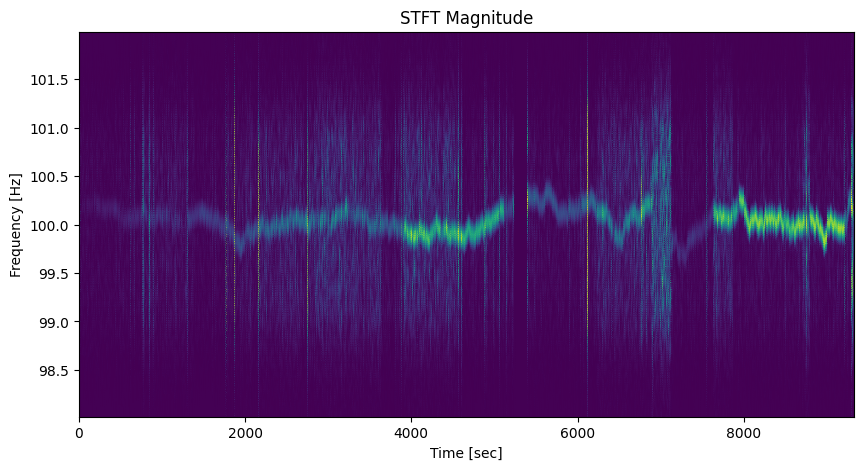

In [12]:
# Plot the STFT over the frequency range of interest
freqs_to_show = np.all([freqs>critical_frequencies[0]-1,freqs<critical_frequencies[1]+1], axis=0)

plt.figure(figsize=(10,5))
plt.pcolormesh(times, freqs[freqs_to_show], np.abs(stft[freqs_to_show,:]),vmin=0, vmax=0.2e6, shading='gouraud')

plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Text(0.5, 1.0, 'Test Signal: Peak Frequency over Time')

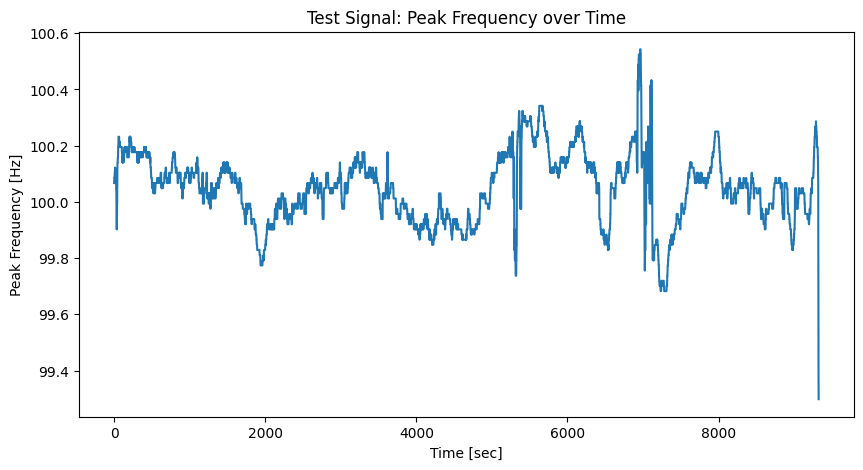

In [13]:
# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(signal_freqs)
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Test Signal: Peak Frequency over Time")

In [14]:
# Cross-correlate test signal peak frequencies with reference frequency data (and normalize)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

harmonic_ratio = filter_center_frequency/grid_frequency

# When correlating, center the frequencies around zero to avoid very large numbers
xcorr = signal.correlate(
        grid_freqs*harmonic_ratio-filter_center_frequency, 
        signal_freqs-filter_center_frequency,
        mode='same'
    ) 

# Normalize to avoid the absolute magnitude of the grid frequency having an effect if different from the nominal value
xcorr_norm = xcorr/moving_average(np.abs(grid_freqs*harmonic_ratio-filter_center_frequency),recording_duration) 

Text(0.5, 1.0, 'Agreement between test and reference signals')

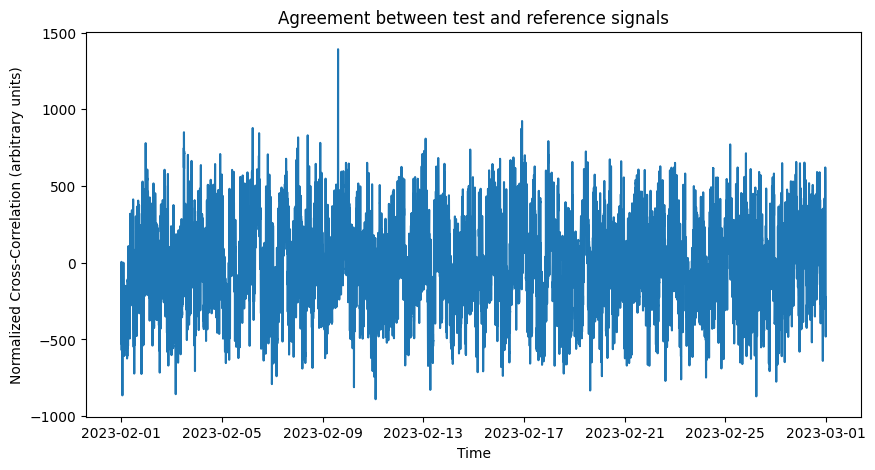

In [15]:
# Plot the Normalized Cross Correlation
plt.figure(figsize=(10,5))
plt.plot(grid_times, xcorr_norm)
plt.xlabel("Time")
plt.ylabel("Normalized Cross-Correlation (arbitrary units)")
plt.title("Agreement between test and reference signals")

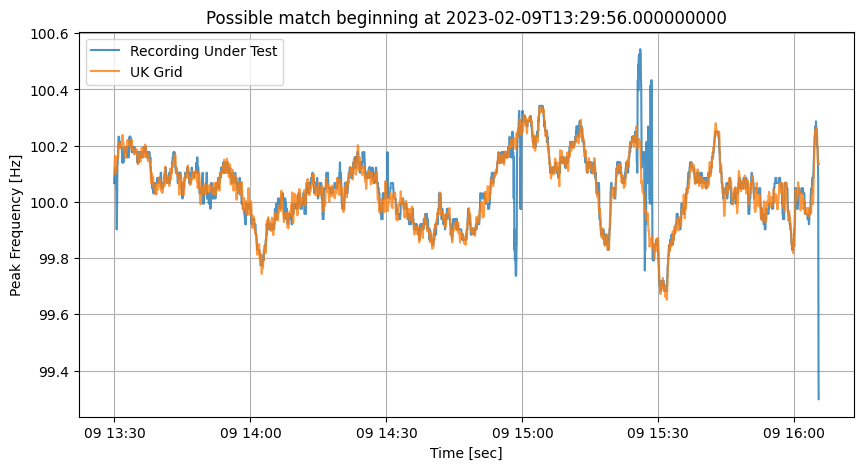

In [16]:
# Create a figure overlaying the test and reference signal for the most probable match
match_center = np.argmax(xcorr_norm)

match_start = match_center-recording_duration//2
match_end = match_start+len(signal_freqs)
plot_idxs = range(match_start, match_end)

plt.figure(figsize=(10,5))
plt.plot(grid_times[plot_idxs],signal_freqs, alpha=0.8)
plt.plot(grid_times[plot_idxs], grid_freqs[plot_idxs]*harmonic_ratio, alpha=0.8)
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.legend(['Recording Under Test', 'UK Grid'])
plt.title(f'Possible match beginning at {grid_times[plot_idxs][0]}')
plt.grid()